# Machine Learning Project - Cryptocurrencies price variations prediction

In [1]:
#import usefull packages
import pandas as pd
import numpy as np
from numpy import absolute
import matplotlib.pyplot as plt
import glob
import ta
import collections
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import plotly.express as px



## See below for detailed steps of the following function (step by step, plots, comments...)

In [2]:
def features_selection(crypto_csv_file):
    
    
    # load data 
    Crypto = pd.read_csv(crypto_csv_file) 
    
    #get the name of the crypto 
    crypto_name = Crypto["Name"][0]
    #print(crypto_name)
    
    # Clean nan values
    Crypto = ta.utils.dropna(Crypto)

    # Add all technical analysis features filling nans values
    Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)
    
    # List of our indicators 
    indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']
    
    # compute the returns 
    Crypto["Returns"] = Crypto["Close"].pct_change()

    # keep only the relevant columns, ie. the ta indicators and the returns. 
    Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN
    
    # standardize
    sc = StandardScaler()
    Z_Crypto = sc.fit_transform(Crypto)
    
    # Lasso regression (alpha = 1.0)
    from sklearn.linear_model import Lasso
    regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
    
    # Rename for clarity 
    # We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date
    X,y = pd.DataFrame(Z_Crypto[:-1,:-1]),pd.DataFrame(Z_Crypto[1:,-1:])
    
    # fit
    regLasso1.fit(X,y)
    
    # obtain coeffficients of the LASSO regression for multiple alphas
    from sklearn.linear_model import lasso_path
    alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

    # number of non-nul coefficients for each alpha
    nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
    alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})
    
    # get the alpha for which we get 8 selected features (and its index)
    # If no such alpha exists, choose an alpha for which we get 7 selected features, etc...
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    while np.isnan(higher_alpha_to_get_8_features) == True :
        alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
        higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
        
    # get the 8 selected features coressponding 
    coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
    index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
    coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
    selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
    
    X,y = Crypto[selected_features], Crypto['Returns']
    
    return crypto_name, selected_features, X, y
    
  

#### Run the Features Selection

In [3]:
# get a list of all csv files 
path = "/Users/nicolaspaganel/Desktop/GitHub/ML_Finance/Crypto df"
all_cryptos_csv_files = glob.glob(path + "/*.csv" )

# initialize dictionary with final selected features for each crypto
selected_features_per_crypto = {}
X_per_crypto = {}
y_per_crypto = {}

# get all selected features for each crpytocurrency 
for crypto_csv_file in all_cryptos_csv_files:
    
    crypto_name, features, X, y = features_selection(crypto_csv_file)
    
    # add selected features, X, and y to the dictionaries,
    selected_features_per_crypto[crypto_name] = features
    X_per_crypto[crypto_name] = X
    y_per_crypto[crypto_name] = y
    

/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.271958532561257, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2710056110477126, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/skle

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5959671029117999, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6312047103274381, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6581116642823872, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8462618750850197, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8389711990880642, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8344674630889131, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8106060750842516, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7906430817470209, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.756082743413117, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6081602120857497, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.606415665582972, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6046654997212499, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9474201060256746, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9456676540967237, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9439543332600806, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9926977864743094, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6820172284592445, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.339317459160611, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2096740711460825, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2094902364885911, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2088399013509843, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.208481803577115, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20877659246298208, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20819335124519966, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0621613280427482, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0398643152841487, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9960971616710594, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8955498847587933, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8932693080864738, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8912362667122125, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.791535702994679, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.296328005869782, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.876868931719855, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.031828483573918, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.799863377640804, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.62883997805011, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.510242409541206, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.11278182217325, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.66630062280399, tolerance: 0.14582900460923673
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9741907793859355, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.83101731524448, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.038078410552316, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.525193080141889, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.484045455232717, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.481391158034967, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.167642888767205, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.234569927070879, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.556359769576829, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.03651818434605, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.63502282703848, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.19111725739663, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.6093748652197, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.02765257935243, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.48409263300323, tolerance: 0.2566554717017103
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15213628760403708, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11255521151343828, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0883919605525989, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4849889542741437, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4799454348009533, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4681878205682324, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8160559953707605, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7040026356634428, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6418078762395396, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7160206121455701, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.813979910501331, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9090398830466597, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1085756617845846, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1236735002123623, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1464490805030607, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.630256904601538, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6151152421999484, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6042242197270298, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6003957731812193, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5940133430528647, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.567368383844382, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6722444678225656, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6808043127481938, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.686828171071113, tolerance: 0.03062468682332362
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0312668421127853, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03179242102311264, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03272187625972833, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038089624979875225, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03817083772824503, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036533621052456056, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36107750133979266, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3418377919570048, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35417287944480336, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43905489884429016, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4311103805780476, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42381184494075796, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8825205960353912, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1269778258910037, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2823957468467313, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.597155665417091, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.25236061740408, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.850852438087173, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.28606451086901, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.563420951341087, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.83118667348772, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.22528259238223, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.13341592479607, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.048067163992897, tolerance: 0.028718285147031904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3966054966297179, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4022161875425354, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4016633714677482, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46965109643542746, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4676606782006729, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4656275143227049, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.161958406103622, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2407551894762037, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2769846711983064, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5350640286449106, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5263454220978474, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.516611646880392, tolerance: 0.14409588790191055
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44585355210551825, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4447984044984423, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44370845039884443, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2642734114187988, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4235518788391346, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.500676815399629, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9132482766772227, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.91364341851272, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9135847676930098, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8251988353008528, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8255287123340622, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8255635745611016, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7569150863942014, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7542120240389067, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.75152821927486, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.18114710617806, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.7653946157659, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.734696250753245, tolerance: 0.14645951355897288
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13038955247341733, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13131222087733363, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12541222060286827, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23164571494382358, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24627254645545804, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25318225558385166, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3619756955357616, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35778010285412165, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35244338903177663, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.321842483488439, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.311896991827666, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.288108099108996, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.778346170176519, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.834427376557443, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.89919138421439, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7836736755838274, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7944639171886365, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8209215735800228, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4494324598345543, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4308927010597188, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.41240597829065, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08573883619976641, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08546309522216688, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0851768424919328, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0294638677632406, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9662235681217908, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9210935270537561, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46723824474366893, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47728055444167694, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5086451077003176, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1554631856869833, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3310628045909993, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4805316300200957, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.036501526236975, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.043749807567735, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0967933098831395, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.03593022953433, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.14523414460362, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.418226114675463, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7906370743207844, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0291143820313664, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1408895445097187, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.317411335252018, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.321263224323502, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.323213634168951, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5245243183117054, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.936853190070906, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.422464792613937, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.33761181001455, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.92414270328936, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.452062173496415, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.50058613201668, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.92457131864921, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.99767192473564, tolerance: 0.27479068741346463
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0064037147903946, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9477003395450083, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9466084635466814, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.794856433101131, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.760136592410163, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7463500727055816, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3707755960285795, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4019681884967667, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.418725201110874, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.79985069177485, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.28623287801122, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.94857557687385, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.780649573656774, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.846375847538184, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.87301219463086, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.189883125648976, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/py

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5761324302552566, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5805694208744399, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5802982150553362, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1366580032033653, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2169639046277325, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2855857551725194, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6198096858691997, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.64050203696263, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6538636281230765, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.208818099979908, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.947613668439658, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.516392426238554, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.826300772168793, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.543959452397985, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.252471373892263, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.854517057703276, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.181988608915844, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.49608406503421, tolerance: 0.07953806087835337
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3377509481881589, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33831277464059895, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3381329897251817, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7169579036140021, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8196889308644586, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.009323981191528, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.606885427976522, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.822589859421896, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.083225550271209, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8033474460223715, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.703024948321854, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.613909039716191, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.411095408915116, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.466353915307764, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.516077386338566, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9185015200926046, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.873395243308096, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.829315478448052, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.790966961347976, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.904682207563837, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.019260409343815, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7312411894390607, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7318318505285788, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7314418255473356, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3987561544413438, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.39348643519088, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3880822832684316, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.287519713974234, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.286664007143827, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.285566159697737, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9004322867617702, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9003037690372366, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7711023984920757, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.439489072537526, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.449709669383537, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.468615344218506, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.189978342945778, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9378454359743955, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.709475520056003, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35613477843025976, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2921286362934552, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3537137251414606, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.415846120848073, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4079256057839302, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4020207889034282, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.66531196584583, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.46265862591963, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.23239128445675, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.505328209238996, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.415298470091784, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.342784802105143, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.03111429841124, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.0353584470181, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.68565819068567, tolerance: 0.2747996044380895
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43694180463012344, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4356480525434563, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4342109676169912, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5035212592667904, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5915620488369768, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5887107538778764, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.9348783535685925, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8733293931675234, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.84109733567152, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.079643488625607, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.82731402589934, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.679653217898704, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.37981479270661, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.05812952096426, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.75460734101648, tolerance: 0.21576235566440066
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWar

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19861996626195833, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1975546811086133, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18891945636300989, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7418584005090452, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7377215577781726, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7283095660836807, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5489393888526592, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5469563553855323, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5445784013805905, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.216914943078336, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.65837814892825, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.19105792586754, tolerance: 0.13643699167854367
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5248353471929477, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.91052921522396, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.78387272358259, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.49407845230826, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.338447453067374, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.1235685963361, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.752604534103057, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.280021252824781, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.76395705207915, tolerance: 0.2525392272409318
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11056471222411801, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10862271811151913, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10803328216968566, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3186316589260514, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.316724118326988, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3148430110876461, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9443814721280432, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9397885573350777, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9351163314910309, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.362917162545955, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.38688684008349, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.373673359345048, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.77682512274089, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.70385105460127, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.570633408604124, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.718585060197711, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.734276383773249, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7462712785395524, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6921633274278065, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7074879219599097, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7221650497317569, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.788708844419034, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.785015139359075, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7811684478538155, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.996336511595473, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.073518810668247, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1376663667001594, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.12266016644276, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.90232738601503, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.72158678866344, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.33914561273286, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284.7216158417564, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.897870715045, tolerance: 0.27464955282018927
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4780148407470506, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4693065532339915, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4630589851160494, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3891858392366885, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3865239972006975, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3838672606257205, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.121347883613339, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.658511875857812, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2291382780583717, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.178046681160026, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.956314591302373, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.807452781579286, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.132059062347707, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.621354141220706, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.127118873835684, tolerance: 0.06909734759461593
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

In [40]:

indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']


indicator_long = ['Accumulation/Distribution Index', 'On-balance volume', 'Chaikin Money Flow',
       'Force Index', 'Money Flow Index', 'Ease of Movement', 'Simple Moving Average Ease of Movement', 'Volume-price trend',
       'Negative Volume Index', 'Volume Weighted Average Price', 'Average True Range', 'Bollinger Channel Middle Band',
       'Bollinger High Band', 'Bollinger Low Band ', 'Bollinger Channel Band Width', 'Bollinger Channel Percentage Band',
       'Bollinger High Band Indicator', 'Bollinger Low Band Indicator', 'Keltner channel',
       'Keltner Channel High Band', 'Keltner Channel Low Band', 'Keltner Channel Band Width', 'Keltner Channel Percentage Band',
       'Keltner Channel High Band Indicator ', 'Keltner Channel Low Band Indicator ', 'Donchian Channel Low Band',
       'Donchian Channel High Band', 'Donchian Channel Middle Band', 'Donchian Channel Band Width', 'Donchian Channel Percentage Band',
       'Ulcer Index', 'Moving Average Convergence Divergence', 'Moving Average Convergence Divergence Line', 'Moving Average Convergence Divergence Histogram',
       'Simple Moving Average Fast', 'Simple Moving Average Slow', 'Exponential Moving Average Fast', 'Exponential Moving Slow',
       'Average Directional Index', 'Positive Average Directional Indicator', 'Negative Average Directional Indicator', 'Positive Vortex Indicator',
       'Negative Vortex Indicator', 'Difference Vortex Indicator', 'Trix',
       'Mass Index', 'Commodity Channel Index', 'Detrended Price Oscillator', 'Know Sure Thing Oscillator',
       'Signal Line Know Sure Thing', 'Diff Know Sure Thing', 'Tenkan-sen (Conversion Line)',
       'Kijun-sen (Base Line)', 'Senkou Span A (Leading Span A)', 'Senkou Span B (Leading Span B)',
       'Visual Senkou Span A (Leading Span A)', 'Visual Senkou Span B (Leading Span B)', 'Aroon Up Channel',
       'Aroon Down Channel', 'Aroon Indicator', 'Parabolic Stop and Reverse up trend value indicator',
       'Parabolic Stop and Reverse down trend value indicator', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'Schaff Trend Cycle', 'Relative Strength Index',
       'Stochastic RSI', 'Stochastic RSI %k', 'Stochastic RSI %d',
       'True strength index', 'Ultimate Oscillator', 'Stochastic Oscillator',
       'Signal Stochastic Oscillator', 'Williams Risk Indicator', 'Awesome Oscillator Indicator', 'Kaufman’s Adaptive Moving Average',
       'Rate of Change', 'The Percentage Price Oscillator', 'Percentage Price Oscillator Signal Line',
       'Percentage Price Oscillator Histogram', 'Daily Return', 'Daily Log Return', 'Cumulative Return']


    
    
dictionary = {'Indicator': indicators, 'Full Name': indicator_long}
df = pd.DataFrame.from_dict(dictionary)

In [41]:
df.to_excel("Indicators.xlsx")

In [44]:
Table_Selected_Features.to_excel("Selected_Features.xlsx")

#### Retults of the Features Selection

In [42]:
# Results as table
pd.set_option("display.max_columns", 100)
Table_Selected_Features = pd.DataFrame({ key:pd.Series(value) for key, value in selected_features_per_crypto.items() }).fillna("NaN")
Table_Selected_Features.index.name = 'Features'
Table_Selected_Features.index += 1
Table_Selected_Features





,NEM,EOS,Monero,Polkadot,USD Coin,Uniswap,Binance Coin,IOTA,Aave,Solana,Bitcoin,Cardano,Tether,Cosmos,Chainlink,Litecoin,XRP,Ethereum,TRON,Stellar,Crypto.com Coin,Dogecoin,Wrapped Bitcoin
Features,,,,,,,,,,,,,,,,,,,,,,,
1,volume_em,volume_obv,volume_fi,volume_obv,volume_fi,volume_em,volume_nvi,volume_adi,volume_cmf,volume_cmf,volume_em,volume_fi,volume_em,volume_em,volatility_kchi,volume_em,volume_mfi,volume_em,volume_em,volume_fi,volume_adi,volume_mfi,volume_cmf
2,volatility_bbl,volume_fi,volatility_kchi,volume_nvi,volume_vpt,volatility_bbw,volatility_bbw,volume_vpt,volume_sma_em,volume_fi,volatility_bbw,volume_nvi,trend_macd_diff,volatility_bbli,trend_macd_diff,volume_sma_em,volatility_bbw,volatility_bbp,volume_nvi,volatility_bbli,volume_vpt,volume_em,volatility_bbw
3,trend_adx,volatility_bbl,volatility_dcl,trend_mass_index,volume_nvi,trend_macd_diff,volatility_bbhi,volatility_bbl,volatility_bbli,volume_vpt,volatility_kchi,volatility_bbhi,trend_sma_slow,trend_visual_ichimoku_a,trend_vortex_ind_pos,volatility_bbli,volatility_bbhi,volatility_bbhi,volatility_bbw,volatility_kcw,volatility_bbhi,volatility_bbhi,volatility_bbli
4,trend_aroon_up,volatility_bbw,trend_vortex_ind_pos,trend_kst_sig,volatility_bbp,trend_mass_index,trend_kst_sig,volatility_bbhi,trend_mass_index,volatility_dcl,trend_dpo,trend_cci,trend_ema_fast,trend_psar_up,trend_vortex_ind_neg,trend_visual_ichimoku_b,volatility_kchi,volatility_kcw,volatility_bbhi,volatility_kchi,volatility_bbli,volatility_bbli,volatility_kchi
5,trend_psar_down_indicator,trend_adx,trend_mass_index,trend_kst_diff,trend_visual_ichimoku_a,trend_visual_ichimoku_b,momentum_rsi,volatility_kcw,trend_visual_ichimoku_a,volatility_dcw,trend_aroon_up,trend_kst_sig,trend_kst_diff,trend_psar_up_indicator,trend_mass_index,trend_psar_down,trend_adx,volatility_kchi,trend_mass_index,trend_adx,trend_psar_up,volatility_kcw,trend_dpo
6,momentum_tsi,trend_kst_sig,trend_stc,trend_visual_ichimoku_b,others_dr,trend_stc,momentum_tsi,volatility_kchi,trend_aroon_down,trend_adx_pos,trend_psar_up_indicator,momentum_roc,trend_psar_down,momentum_stoch_rsi,trend_stc,momentum_tsi,trend_psar_down,trend_cci,trend_dpo,trend_psar_up,momentum_rsi,volatility_dcp,trend_visual_ichimoku_b
7,momentum_stoch_signal,trend_aroon_up,momentum_ppo,momentum_uo,others_cr,others_dlr,momentum_uo,momentum_ppo,momentum_uo,momentum_roc,momentum_stoch_rsi,momentum_ppo_hist,momentum_ao,momentum_stoch_rsi_k,others_dlr,momentum_uo,momentum_rsi,trend_aroon_up,trend_ichimoku_base,trend_stc,momentum_ppo,momentum_uo,trend_psar_up_indicator
8,others_dlr,momentum_tsi,others_dlr,others_dlr,NaN,others_cr,momentum_ppo,others_dlr,others_cr,others_dlr,others_dlr,others_dlr,others_cr,others_dlr,others_cr,NaN,momentum_stoch_rsi,others_cr,trend_psar_up,others_dr,momentum_ppo_hist,others_dr,others_dlr


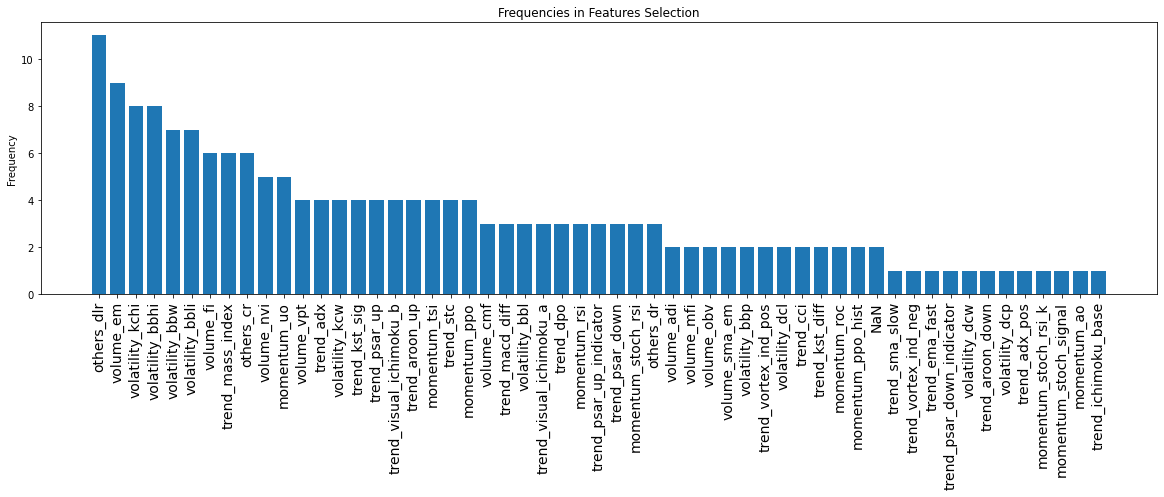

In [388]:
# Plot the dsitribution of apparition of the different features 
liste = Table_Selected_Features.values.tolist()
full_liste = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        full_liste.append(liste[i][j])
        
occurrences = collections.Counter(full_liste)
y = [count for tag, count in occurrences.most_common()]
x = [tag for tag, count in occurrences.most_common()]

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=10) 

f, ax = plt.subplots(figsize=(20,5))
plt.bar(x, y)
plt.title("Frequencies in Features Selection")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.savefig('Frequencies in Features Seleciton.pdf', bbox_inches='tight')
plt.show()




## DETAILED STEPS of the Features Selection function

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


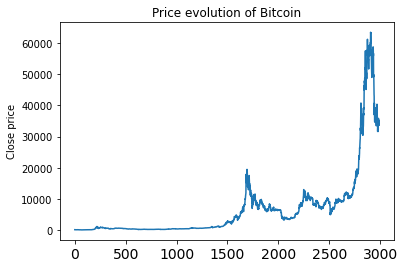

In [389]:
# load data 

Crypto = pd.read_csv("/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df/coin_Bitcoin.csv") 

# let's have a look at the data
plt.plot(Crypto["Close"])
plt.ylabel("Close price")
crypto_name = Crypto["Name"][0]
plt.title("Price evolution of " + crypto_name)
Crypto.head()

In [390]:
# Clean nan values

Crypto = ta.utils.dropna(Crypto)

# Add all technical analysis features filling nans values

Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)

#print(Cardano.columns)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [391]:
Crypto

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
242,243,Bitcoin,BTC,2013-12-27 23:59:59,777.510010,713.599976,763.280029,735.070007,4.686270e+07,8.955395e+09,-1.537645e+07,4.686270e+07,-0.328117,0.000000e+00,0.000000,0.000000,-6.091301e+06,742.059998,50.000000,1000.000000,735.070007,735.070007,735.070007,0.000000,0.000000,0.0,0.0,742.059998,805.970032,678.149963,17.225032,0.445314,0.0,0.0,713.599976,777.510010,745.554993,8.694415,0.335941,0.000000,0.000000,0.000000,0.000000,0.000000,735.070007,735.070007,735.070007,735.070007,0.000000,0.000000,0.000000,-89.523154,1.000000,6545.202219,-899.032621,-899.032621,0.000000,745.554993,745.554993,745.554993,745.554993,0.000000,0.000000,0.000000,0.000000,0.000000,7158.248889,7044.852011,4.0,4.0,0.0,-1.000000,-1.000000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.594148,33.594148,-66.405852,0.000000,0.000000,0.000000,0.000000,0.000000,735.070007,-89.903262,0.000000,0.000000
243,244,Bitcoin,BTC,2013-12-28 23:59:59,747.059998,705.349976,737.979980,727.830017,3.250580e+07,8.869919e+09,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,-2482.908219,-2482.908219,-4.245126e+07,735.788338,0.000000,990.150611,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.005063,0.010919,-0.005856,-0.001924,1.943639,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,0.000000,0.000000,0.000000,0.000000,-66.666667,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,0.000000,-2.500653,-0.500131,-2.000522,731.817595,-0.984939,-0.989821,-0.984939
244,245,Bitcoin,BTC,2013-12-29 23:59:59,748.609985,714.440002,728.049988,745.049988,1.901130e+07,9.082104e+09,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,956.192156,-763.358031,1.296324e+05,735.835681,37.199037,1013.576912,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.011550,0.015774,-0.004224,-0.000474,2.831246,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,0.000000,0.000000,0.000000,0.000000,13.251992,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,0.000000,-7.088933,-1.817891,-5.

In [392]:
# List of our indicators 

indicators = ['Date','volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [393]:
# compute the returns 

Crypto["Returns"] = Crypto["Close"].pct_change()

# keep only the relevant columns, ie. the ta indicators and the returns. 

Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN

Crypto

,Date,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Returns
243,2013-12-28 23:59:59,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939,-0.009849
244,2013-12-29 23:59:59,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1.817891,-5.271042,2.365933,2.338379,1.357691,0.023659
245,2013-12-30 23:59:59,6.464174e+06,5.407590e+07,0.054281,-1.000401e+08,55.625599,2787.135170,420.139703,7.577494e+05,1013.576912,739.050431,0.000000,741.020004,762.325663,719.714345,5.750360,0.854601,0.0,0.0,739.790827,781.328334,698.253321,11.229527,0.696680,0.0,0.0,705.349976,777.510010,741.429993,9.737933,0.703714,0.000000,1.956971,0.373502,1.583470,741.020004,741.020004,738.811690,736.854718,0.000000,0.000000,0.000000,0.019325,0.016967,0.002359,0.006118,3.661183,115.325833,6539.252222,-898.215344,-898.921247,0.705903,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,16.0,8.0,8.0,-1.000000,776.248610,0.0,0.0,0.000000,81.260429,0.000000,0.000000,0.000000,-87.732937,41.516721,70.371404,52.180354,-29.628596,0.000000,746.502271,0.000000,-10.620253,-3.578364,-7.041890,1.487151,1.476201,2.865033,0.014872
246,2013-12-31 23:59:59,1.510844e+07,3.317860e+07,0.107929,-9.207753e+07,42.962004,-433.779509,206.659900,2.493640e+05,1013.576912,740.822352,0.000000,743.618005,765.323734,721.912277,5.837871,0.739384,0.0,0.0,742.016663,

In [394]:
# standardize

sc = StandardScaler()
Z_Crypto_train = sc.fit_transform(Crypto.iloc[:,1:])

In [395]:
# Lasso regression (alpha = 1.0)

from sklearn.linear_model import Lasso
regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
#print(regLasso1)

In [396]:
# Rename for clarity 
# We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date

X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])

In [397]:
# fit

regLasso1.fit(X,y)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Lasso(fit_intercept=False, normalize=False)

In [398]:
# obtain coeffficients of the LASSO regression for multiple alphas
from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33702039463105393, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2893979007485541, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39865333910756817, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.193278792944966, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1932817519655146, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1906023758929223, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3232136341453042, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3236610193193883, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.322959329474088, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.524524318607746, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9368531902496215, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.422464791725815, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.96669287695113, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.6870718722148, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.33761180954389, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\s

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.10016684595394, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.31176687889342, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.62188810880502, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\

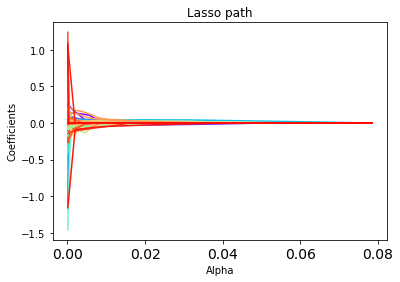

In [399]:
# graph of lasso path (coefficients given alpha)
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,len(indicators)))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alpha_for_path,coefs_lasso[0][i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.savefig('lasso path.pdf', bbox_inches='tight')
plt.show()

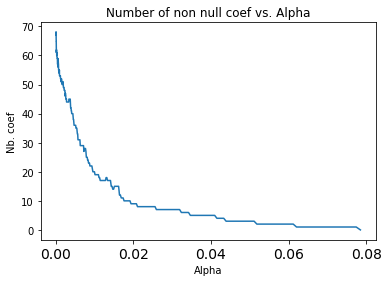

In [400]:
# number of non-nul coefficients for each alpha

nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. coef') 
plt.title('Number of non null coef vs. Alpha') 
plt.savefig('non zero coef.pdf', bbox_inches='tight')
plt.show()

In [401]:
# get the alpha for which we get 8 selected features (and its index)
# If no such alpha exists, choose an alpha for which we get 7 selected features, etc...

alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
while np.isnan(higher_alpha_to_get_8_features) == True :
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
index_higher_alpha_to_get_8_features

81

In [402]:
higher_alpha_to_get_8_features

0.025588019392882133

In [403]:
# get the 8 selected features coressponding 

coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
selected_features

['volume_mfi',
 'volatility_bbl',
 'volatility_kcp',
 'trend_cci',
 'trend_visual_ichimoku_b',
 'trend_psar_down',
 'momentum_rsi',
 'others_dr']

In [404]:
Z = Crypto['Date']
Z = np.array(Z)

# Long-Short term memory


In [405]:
sc = MinMaxScaler(feature_range = (0,1))
y = Crypto[['Returns']]
y = sc.fit_transform(y)
X = Crypto[Table_Selected_Features['Bitcoin']]
X = sc.fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7
0,0.520644,0.000000,0.0,0.929691,0.000000,0.0,0.000000,0.659321
1,0.546767,0.018294,0.0,0.929354,0.083333,0.0,0.000000,0.707566
2,0.560674,0.037142,0.0,0.928979,0.125000,0.0,0.000000,0.695068
3,0.536209,0.038004,0.0,0.928785,0.125000,0.0,0.000000,0.669599
4,0.550369,0.055959,0.0,0.928441,0.208333,1.0,0.000000,0.706722
...,...,...,...,...,...,...,...,...
2743,0.525640,0.270525,0.0,0.168530,0.291667,0.0,0.688444,0.687632
2744,0.577088,0.256257,0.0,0.246718,0.250000,0.0,0.847041,0.706292
2745,0.586988,0.225167,0.0,0.355681,0.208333,0.0,0.973694,0.699333
2746,0.485469,0.182023,0.0,0.450392,0.166667,0.0,0.619650,0.608909


In [406]:
#Setting The training set ratio
train_split = 80

#Rounding the training set length to avoid fractions
train_len = round(len(X)*(train_split/100))

#Setting the Test set length
test_len = round(len(X)-train_len)

#Splitting the data based on the calculated lengths
train_df = X.head(train_len)
test_df = X.tail(test_len)

#Printing the shapes of training and test sets

print("Shape Of Training Set :", train_df.shape)
print("Shape Of Test Set :", test_df.shape)

Shape Of Training Set : (2198, 8)
Shape Of Test Set : (550, 8)


In [407]:
#dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])

#dataset_train.set_index('Date', inplace = True)
#dataset_train.sort_values(by='Date',ascending=True, inplace = True)



In [408]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional, Reshape, CuDNNLSTM
from keras.layers import Dropout
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
"""
### Turn each signal into a labeled dataset
"""
#window_size = 30   # num. days per training sample
#batch_size = 128   # num. of samples per epoch
#buffer_size = 1000 # num of samples in memory for random selection
#split_time = 1748  # where to split the data for training/validation
#sequence_length = 50
#lookback = sequence_length - 1
#
#def window_dataset(series, window_size, batch_size, shuffle_buffer):
#    """Funtion to turn time series data into set of sequences 
#    where the last value is the intended output of our model"""
#    ser = tf.expand_dims(series, axis=-1)
#    data = tf.data.Dataset.from_tensor_slices(series)
#    data = data.window(window_size + 1, shift=1, drop_remainder=True)
#    data = data.flat_map(lambda w: w.batch(window_size + 1))
#    data = data.shuffle(shuffle_buffer)
#    data = data.map(lambda w: (w[:-1], w[1:]))
#    return data.batch(batch_size).prefetch(1)
#
#
#X_train = X.iloc[:split_time,:]
#X_test = X.iloc[split_time:,:]
#y_train = y.iloc[:split_time,:]
#y_test = y.iloc[split_time:,:]
#print(f"Training data shape: {X_train.shape}")
#print(f"Validation data shape: {X_test.shape}")
#
#train_set = window_dataset(X_train,window_size,batch_size,buffer_size)

'\n### Turn each signal into a labeled dataset\n'

In [409]:
sc = MinMaxScaler(feature_range = (0,1))

def process_data(unprocess_data , length_senquence, column = 1):
  
  #Select the feature/column 
  data = unprocess_data.iloc[:, column].values
  data = data.reshape(-1, 1)
    
  #Feature Scaling
  data = sc.fit_transform(data)
 
  
  #Making sequences
  
  X = []
  y = []

  for i in range(length_senquence, len(data)):
      X.append(data[i-length_senquence:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  # Reshaping
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

In [410]:
#Setting the sequence length (Try different values)
sequence_length = 50

#Choosing the idex of the Close column
comumn_index= 3

#Preprocessing the training set
X_train, y_train = process_data(Crypto , sequence_length, comumn_index)

In [411]:
X_train.shape

(2698, 50, 1)

In [412]:
y_train.shape

(2698,)

In [413]:
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [414]:
#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae', 'mape'])

In [415]:
regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

Epoch 1/15
54/54 [==============================] - 20s 150ms/step - loss: 0.0339 - mse: 0.0339 - mae: 0.1400 - mape: 105703.2031
Epoch 2/15
54/54 [==============================] - 8s 142ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.1006 - mape: 92707.3359
Epoch 3/15
54/54 [==============================] - 8s 147ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0895 - mape: 62197.6328
Epoch 4/15
54/54 [==============================] - 7s 133ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0782 - mape: 81283.2812
Epoch 5/15
54/54 [==============================] - 7s 136ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0740 - mape: 82359.1016
Epoch 6/15
54/54 [==============================] - 8s 138ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0737 - mape: 82884.2188
Epoch 7/15
54/54 [==============================] - 7s 134ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0691 - mape: 85779.1016
Epoch 8/15
54/54 [==============================] - 7s 130ms/step - loss: 0.0073 - mse: 0.0073 - mae: 

In [416]:
#Converting the Date colum values from object to datetime format
#dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])

In [417]:
#dataset_test.set_index('Date', inplace = True)

In [418]:
#dataset_test.sort_values(by='Date',ascending=True, inplace = True)
train_df

,0,1,2,3,4,5,6,7
0,0.520644,0.000000,0.0,0.929691,0.000000,0.0,0.000000,0.659321
1,0.546767,0.018294,0.0,0.929354,0.083333,0.0,0.000000,0.707566
2,0.560674,0.037142,0.0,0.928979,0.125000,0.0,0.000000,0.695068
3,0.536209,0.038004,0.0,0.928785,0.125000,0.0,0.000000,0.669599
4,0.550369,0.055959,0.0,0.928441,0.208333,1.0,0.000000,0.706722
...,...,...,...,...,...,...,...,...
2193,0.539318,0.076307,0.0,0.440599,0.083333,0.0,0.807753,0.648124
2194,0.538833,0.076393,0.0,0.441877,0.041667,0.0,0.028046,0.653777
2195,0.539381,0.076428,0.0,0.439978,0.000000,0.0,0.056962,0.674994
2196,0.538079,0.080380,0.0,0.464886,0.541667,0.0,0.000000,0.629786


In [419]:
test_set = pd.concat((train_df.tail(sequence_length), test_df), axis = 0)

In [420]:
test_set.shape

(600, 8)

In [421]:
test_set

,0,1,2,3,4,5,6,7
2148,0.538202,0.105966,0.0,0.465130,0.208333,0.0,0.000000,0.637242
2149,0.539097,0.108805,0.0,0.463639,0.166667,0.0,0.078700,0.683667
2150,0.540255,0.115228,0.0,0.467529,0.125000,0.0,0.116425,0.678276
2151,0.537486,0.125661,0.0,0.464745,0.083333,0.0,0.000000,0.627537
2152,0.537179,0.141381,0.0,0.434026,0.041667,0.0,0.000000,0.655563
...,...,...,...,...,...,...,...,...
2743,0.525640,0.270525,0.0,0.168530,0.291667,0.0,0.688444,0.687632
2744,0.577088,0.256257,0.0,0.246718,0.250000,0.0,0.847041,0.706292
2745,0.586988,0.225167,0.0,0.355681,0.208333,0.0,0.973694,0.699333
2746,0.485469,0.182023,0.0,0.450392,0.166667,0.0,0.619650,0.608909


In [422]:
x_test, y_true = process_data(test_set , sequence_length, comumn_index)


In [423]:
x_test

array([[[0.46513007],
        [0.46363865],
        [0.46752865],
        ...,
        [0.43997781],
        [0.46488637],
        [0.45245809]],

       [[0.46363865],
        [0.46752865],
        [0.46474493],
        ...,
        [0.46488637],
        [0.45245809],
        [0.44903314]],

       [[0.46752865],
        [0.46474493],
        [0.43402608],
        ...,
        [0.45245809],
        [0.44903314],
        [0.44372464]],

       ...,

       [[0.33136278],
        [0.6639881 ],
        [0.63029116],
        ...,
        [0.46171137],
        [0.16853017],
        [0.24671757]],

       [[0.6639881 ],
        [0.63029116],
        [0.74608399],
        ...,
        [0.16853017],
        [0.24671757],
        [0.35568121]],

       [[0.63029116],
        [0.74608399],
        [0.91542096],
        ...,
        [0.24671757],
        [0.35568121],
        [0.45039201]]])

In [424]:
#Predicting the closing price of the test data
predicted_price = regressor.predict(x_test)

In [425]:
#Inversing the scaled values 
predicted_price = sc.inverse_transform(predicted_price)

In [426]:
#Inversing the scaled actual prices from test data
crypto_price = sc.inverse_transform(y_true.reshape(-1, 1))

In [427]:
# A Method to plot predicted pirce vs Actual price
def predicted_plot(crypto_price, predicted_price, title, x_label, y_label):
  plt.plot(crypto_price, color = 'green', label = 'Real Crypto Price')
  plt.plot(predicted_price, color = 'red', label = 'Predicted Crypto Price')
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Bitcoin Stock Price')
  plt.legend()
  plt.show()

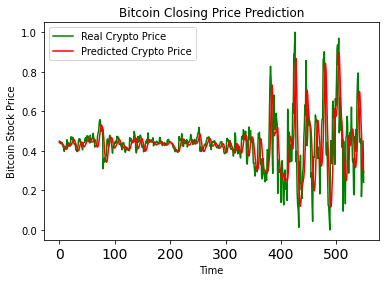

In [428]:
predicted_plot(crypto_price, predicted_price, "Bitcoin Closing Price Prediction", "Time", "Closing Price")


In [429]:
#convert the results into a df
predicted_price = pd.DataFrame(predicted_price)
crypto_price = pd.DataFrame(crypto_price)
predicted_price[:]


,0
0,0.442245
1,0.446011
2,0.446623
3,0.444227
4,0.440468
...,...
545,0.503230
546,0.423789
547,0.349999
548,0.303124


In [430]:
#create two df one that goes from 0 to 549 and one from 1 to 550, which will allow us the compare the variation from one day to another
predicted_price1 = predicted_price[:549]

predicted_price2 = predicted_price[1:]
predicted_price2.index-=1
predicted_price1

,0
0,0.442245
1,0.446011
2,0.446623
3,0.444227
4,0.440468
...,...
544,0.564988
545,0.503230
546,0.423789
547,0.349999


In [431]:
predicted_price2 = pd.DataFrame(predicted_price2)
predicted_price1 = pd.DataFrame(predicted_price1)
predicted_price2>=predicted_price1

,0
0,True
1,True
2,False
3,False
4,False
...,...
544,False
545,False
546,False
547,False


In [432]:
#create a column where the value takes 1 if the normalized return increases and 0 otherwise
predicted_price1['positive?'] = np.where(predicted_price2>=predicted_price1, 1, 0)


In [433]:
predicted_price1

,0,positive?
0,0.442245,1
1,0.446011,1
2,0.446623,0
3,0.444227,0
4,0.440468,0
...,...,...
544,0.564988,0
545,0.503230,0
546,0.423789,0
547,0.349999,0


In [434]:
df = predicted_price1.iloc[:,1]


In [435]:
#repeat the prior steps for the real returns
crypto_price1 = crypto_price[:549]

crypto_price2 = crypto_price[1:]
crypto_price2.index-=1
crypto_price1

,0
0,0.449033
1,0.443725
2,0.436830
3,0.437335
4,0.436148
...,...
544,0.461711
545,0.168530
546,0.246718
547,0.355681


In [436]:
crypto_price2 = pd.DataFrame(crypto_price2)
crypto_price1 = pd.DataFrame(crypto_price1)
crypto_price2>=crypto_price1

,0
0,False
1,False
2,True
3,False
4,True
...,...
544,False
545,True
546,True
547,True


In [437]:
crypto_price1['positive?'] = np.where(crypto_price2>=crypto_price1, 1, 0)
df1 = crypto_price1.iloc[:,1]

In [439]:
df1

0      0
1      0
2      1
3      0
4      1
      ..
544    0
545    1
546    1
547    1
548    0
Name: positive?, Length: 549, dtype: int32

In [442]:
#compare the real and predicted returns by creating an array which takes one if both the predicted and real retiurn go in the same direction and takes 0 otherwise.
df2 = np.where(df == df1,1,0)

In [444]:
df2.sum()

240

In [445]:
df2

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,

In [446]:
crypto_price

,0
0,0.449033
1,0.443725
2,0.436830
3,0.437335
4,0.436148
...,...
545,0.168530
546,0.246718
547,0.355681
548,0.450392


In [447]:
predicted_price

,0
0,0.442245
1,0.446011
2,0.446623
3,0.444227
4,0.440468
...,...
545,0.503230
546,0.423789
547,0.349999
548,0.303124
